In [1]:
from torch import nn
import matplotlib.pyplot as plt
from torchsummary import summary

import lightdde as dde
from essential import *
from qmodels import *

# Inference

In [2]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=5000,
)

# Models (pick one!)

## classic model

In [6]:
net = ClassicNet(in_dim=2, out_dim=3, hidden_dim=16,)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/classic_1000e_tanh/",
    log_every=10,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## FNN model

In [3]:
net = FNN()

model = dde.Model(
    data=data,
    model=net,
    save_path="models/FNN_1000e_tanh/",
    log_every=100,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## quantum model

In [3]:
net = QuantumNet(in_dim=2, out_dim=3, activation=nn.ReLU)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/quantum_1000e_relu/",
    log_every=20,
    save_every=10,
)

model.compile()

Loaded snapshot at epoch 2000


In [4]:
summary(net, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        TorchLayer-1                    [-1, 2]               0
            Linear-2                    [-1, 1]               3
           QScalar-3                    [-1, 1]               0
            Linear-4                   [-1, 10]              30
              ReLU-5                   [-1, 10]               0
            Linear-6                   [-1, 10]             110
              ReLU-7                   [-1, 10]               0
            Linear-8                    [-1, 1]              11
           CScalar-9                    [-1, 1]               0
       TorchLayer-10                    [-1, 2]               0
           Linear-11                    [-1, 1]               3
          QScalar-12                    [-1, 1]               0
           Linear-13                   [-1, 10]              30
             ReLU-14                   

# Plotting

Executed in 57.48 sec.


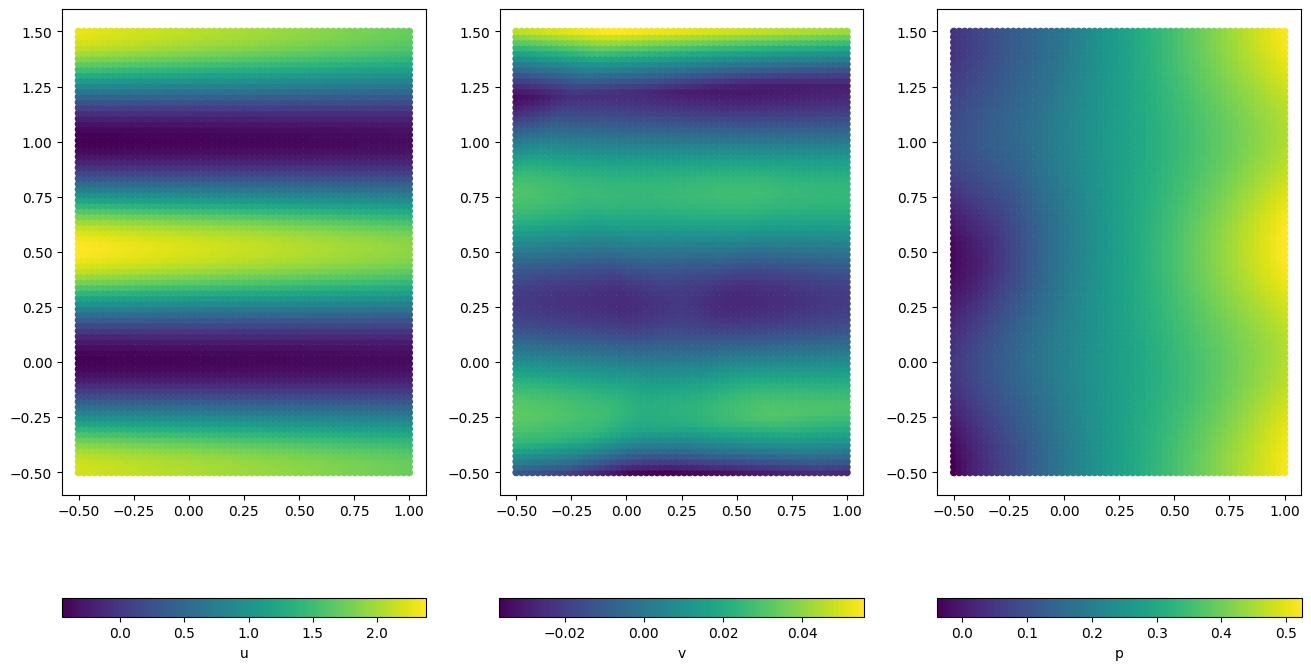

''

In [5]:
dde.scatter_plot(model, s=20)
;

# Load csv loss

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df_q = pd.read_csv("models/quantum_1000e_tanh/log.csv", index_col="epoch")
df_c = pd.read_csv("models/quantum_1000e_relu/log.csv", index_col="epoch")

In [8]:
df_q

,loss_train,u_err,v_err,p_err
epoch,,,,
20,6.667488,1.029987,0.634691,0.814426
40,4.700420,1.019061,0.474912,0.806727
60,3.515687,1.002963,0.356917,0.805214
80,2.874638,0.987574,0.286741,0.802304
100,2.538923,0.971233,0.256901,0.794252
120,2.323670,0.953957,0.245109,0.783643
140,2.156816,0.936742,0.237398,0.774771
160,2.016536,0.920153,0.231119,0.769365
180,1.892975,0.904293,0.226499,0.766992


In [9]:
len(df_q)

50

In [10]:
len(df_c)

100

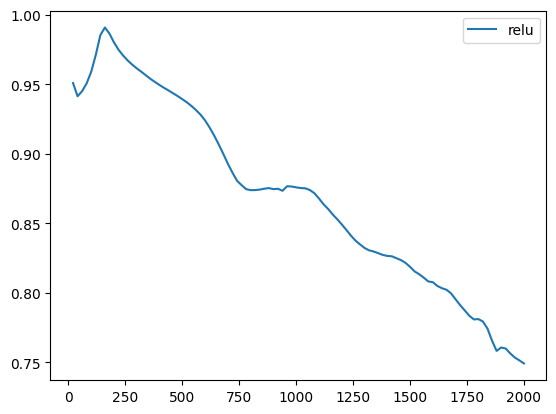

In [17]:
err = "p_err"
#plt.plot(df_q.index, df_q[err], label="tanh")
plt.plot(df_c.index, df_c[err], label="relu")
plt.legend()
plt.show()